In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn, relu
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from time import time
from model import LinearVAE, pPCA

In [2]:
class config:
    latent_dim = 200
    data_size = 1000
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(config.device)

def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

cuda:0


In [3]:
start = time()
seed_torch(0)
latent_dim = config.latent_dim
data_size = config.data_size
device = config.device
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
loader = mnist_data.data[:data_size].view(-1, 784) / 255.0
loader = loader.to(device)

In [4]:
# Linear VAE
analytic_model = LinearVAE(784, latent_dim, 784, 1.0, True, mode='Analytic').to(device)
stochastic_model = LinearVAE(784, latent_dim, 784, 1.0, True, mode='Stochastic').to(device)

ana_optimizer = optim.Adam(analytic_model.parameters(), lr=0.0005)
sto_optimizer = optim.Adam(stochastic_model.parameters(), lr=0.0005)

ana_elbo_result = []
sto_elbo_result = []

for i in range(20000):
    ana_elbo = analytic_model(loader)
    ana_optimizer.zero_grad()
    ana_elbo.backward()
    ana_optimizer.step()
    
    sto_elbo = stochastic_model(loader)
    sto_optimizer.zero_grad()
    sto_elbo.backward()
    sto_optimizer.step()
    
    ana_elbo_detach = ana_elbo.detach().cpu().numpy()
    sto_elbo_detach = sto_elbo.detach().cpu().numpy()
    if (np.abs(-ana_elbo_detach - 961) < 1)  and (np.abs(-sto_elbo_detach - 961) < 1):
        print("End Epoch:{}".format(i))
        end = time()
        print("total time:{}s".format(end - start))
        break
    if i % 500 == 0:
        ana_elbo_result.append(-ana_elbo_detach)
        sto_elbo_result.append(-sto_elbo_detach)
        print("Epoch:{},\t Analytic ELBO:{},\t Stochastic ELBO:{}".format(i,-ana_elbo_detach,-sto_elbo_detach))

Epoch:0,	 Analytic ELBO:-1793.98095703125,	 Stochastic ELBO:-1947.8914794921875
Epoch:500,	 Analytic ELBO:-1078.3211669921875,	 Stochastic ELBO:-1095.45166015625
Epoch:1000,	 Analytic ELBO:-950.5664672851562,	 Stochastic ELBO:-960.9899291992188
Epoch:1500,	 Analytic ELBO:-839.693115234375,	 Stochastic ELBO:-845.9015502929688
Epoch:2000,	 Analytic ELBO:-736.1995849609375,	 Stochastic ELBO:-741.3532104492188
Epoch:2500,	 Analytic ELBO:-637.565185546875,	 Stochastic ELBO:-641.1238403320312
Epoch:3000,	 Analytic ELBO:-542.4310302734375,	 Stochastic ELBO:-545.2632446289062
Epoch:3500,	 Analytic ELBO:-449.9338073730469,	 Stochastic ELBO:-452.3328552246094
Epoch:4000,	 Analytic ELBO:-359.6425476074219,	 Stochastic ELBO:-361.36669921875
Epoch:4500,	 Analytic ELBO:-271.1060485839844,	 Stochastic ELBO:-273.268798828125
Epoch:5000,	 Analytic ELBO:-184.28289794921875,	 Stochastic ELBO:-186.54689025878906
Epoch:5500,	 Analytic ELBO:-99.25252532958984,	 Stochastic ELBO:-102.0621337890625
Epoch:6000,

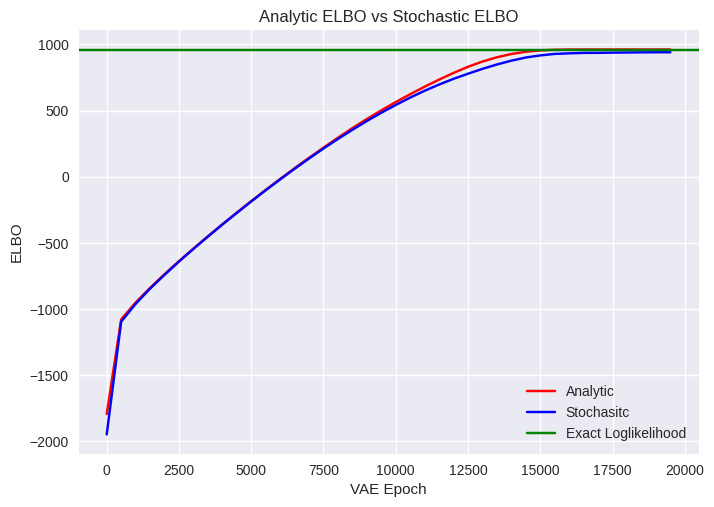

In [6]:
plt.plot(500*np.arange(len(ana_elbo_result)),ana_elbo_result,label="Analytic",color='red')
plt.plot(500*np.arange(len(sto_elbo_result)),sto_elbo_result,label="Stochasitc",color='blue')
plt.axhline(y=961.9913221097786,label="Exact Loglikelihood",color='green')
plt.xlabel("VAE Epoch")
plt.ylabel("ELBO")
plt.legend(loc = "best")
plt.title("Analytic ELBO vs Stochastic ELBO")
plt.style.use('seaborn')
plt.savefig("Analytic_ELBO_vs_Stochastic_ELBO.jpg",dpi=500)
plt.show()